# Medium Analytics
##### by  Harsha, Jenna, Shinu, and Jesse



### Part 0: Check the robots.txt
to see what you can scrape at: https://medium.com/robots.txt

## Part 1: Sample - looking at a single page
basic webpage accessing and scraping the top of the art topics page (without scrolling). Only about 10 articles. Was able to retrieve links


In [2]:
#imports
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

#the url topic (root url)
url = "https://medium.com/topic/art"

#requesting the url to get access to the page
r = requests.get(url)
#should be 200
print(r)

#parsing in the information
soup = BeautifulSoup(r.content, "html5lib")

<Response [200]>


In [6]:
#look at the html in nice format
print(soup.prettify()[:500])

<!DOCTYPE html>
<html lang="en">
 <head>
  <script>
   !function(c,f){var t,o,i,e=[],r={passive:!0,capture:!0},n=new Date,a="pointerup",u="pointercancel";function p(n,e){t||(t=e,o=n,i=new Date,w(f),s())}function s(){0<=o&&o<i-n&&(e.forEach(function(n){n(o,t)}),e=[])}function l(n){if(n.cancelable){var e=(1e12<n.timeStamp?new Date:performance.now())-n.timeStamp;"pointerdown"==n.type?function(n,e){function t(){p(n,e),i()}function o(){i()}function i(){f(a,t,r),f(u,o,r)}c(a,t,r),c(u,o,r)}(e,n):p(e,n)


In [5]:
### REGEX ###
#example of link I want to get
'<a href="https://psiloveyou.xyz/remembering-the-terrible-cb7ebf24a6da?source=topic_page---------6------------------1"'

#Regex pattern to get html tags (want entire html)
#divs and labels were too confusing so this was the best/easiest way to get urls
pattern = 'href="(.{5,100}source=topic_page\-+\d\-+\d)'

#find all the htmls in the string using REGEX
result = re.findall(pattern, str(soup))
result[:5]

['/@Rashmee/questions-still-linger-about-colonial-era-artefacts-18876e0e824?source=topic_page---------0------------------1',
 '/@Rashmee/questions-still-linger-about-colonial-era-artefacts-18876e0e824?source=topic_page---------0------------------1',
 '/@Rashmee/questions-still-linger-about-colonial-era-artefacts-18876e0e824?source=topic_page---------0------------------1',
 '/@Rashmee?source=topic_page---------0------------------1',
 '/@Rashmee/questions-still-linger-about-colonial-era-artefacts-18876e0e824?source=topic_page---------0------------------1',
 '/@chrisjones_32882/reading-art-paul-klees-twittering-machine-e36b88609c58?source=topic_page---------1------------------1',
 '/@chrisjones_32882/reading-art-paul-klees-twittering-machine-e36b88609c58?source=topic_page---------1------------------1',
 '/@chrisjones_32882/reading-art-paul-klees-twittering-machine-e36b88609c58?source=topic_page---------1------------------1',
 '/@chrisjones_32882?source=topic_page---------1----------------

## Part 2: Using Selenium to Scroll and Get all the URLs at once 
creating a new browser that will automatically scroll down the page for you. Using the developer tools it was noticed that "POST" calls were being made when the scroll down occurred, but no "GET" calls were made. Thus, since we could not use the GET calls, we decided to use the scroller instead.

In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [16]:
#opens a new browser to scroll down automatically
browser = webdriver.Chrome(executable_path = r"C:\Users\jesse\Downloads\chromedriver_win32\chromedriver.exe")
browser.get("https://medium.com/topic/politics")

In [ ]:
#code based off of stackoverflow code #4
time.sleep(1)
elem = browser.find_element_by_tag_name("body")
pagedowns = 100000
while pagedowns:
    elem.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)
    pagedowns-=1
    
pages = browser.page_source

## Part 3: Processing
using the regex tested above, able to get html links from the browser object. Then we dropped duplicates and cleaned the links. Some of the processing is shown below:

In [29]:
#Regex pattern to get html tags
pattern = 'href="(.{5,100}source=topic_page\-+\d{1,5}\-+\d)'

#get all the html links based on the pattern
result = re.findall(pattern, pages)

#put into a series to process
html_links = pd.Series(result)

#export to csv for safekeeping
html_links.to_csv("htmls_politics.csv")

['https://gen.medium.com/does-cutting-u-s-aid-help-or-hurt-central-america-55db640f2add?source=topic_page---------5109------------------1',
 'https://gen.medium.com/does-cutting-u-s-aid-help-or-hurt-central-america-55db640f2add?source=topic_page---------5109------------------1',
 '/@johnbwashington?source=topic_page---------5109------------------1',
 'https://gen.medium.com/?source=topic_page---------5109------------------1',
 'https://gen.medium.com/does-cutting-u-s-aid-help-or-hurt-central-america-55db640f2add?source=topic_page---------5109------------------1']

In [36]:
#using the saved csv
topic = pd.read_csv("htmls_politics.csv", index_col = 0, header = None)

#drop all the duplicates
htmls = topic.drop_duplicates().reset_index(drop=True)

In [32]:
#a look at some of the htmls... seems as though some are missing the "https:"
topics.head()

0    https://arcdigital.media/trumps-trade-war-is-k...
1    /@maxburnswrites?source=topic_page---------0--...
2    https://arcdigital.media/?source=topic_page---...
3    /@fnfwriter?source=topic_page---------1-------...
4    /politically-speaking?source=topic_page-------...
dtype: object

In [70]:
#just get the url column
htmls = htmls[1]

#there are some repeat html links, so getting rid of the repeats
clean_htmls = htmls[~htmls.str.contains(r"^.{2,30}\?source=topic")]

In [73]:
### ADD HTTP to some versus not others ###

#links with https already included (no user in url)
with_http = clean_htmls[clean_htmls.str.contains("https://")].reset_index(drop=True)

#links without https:
without_http = clean_htmls[~clean_htmls.str.contains("https://")].reset_index(drop=True)

In [75]:
#adding medium before in order to get the full url
urls = "https://medium.com" + without_http

In [82]:
#combine all the urls together
pd.concat([urls, with_http], ignore_index = True).tail()

1679    https://magenta.as/legendary-cartoonist-ben-ka...
1680    https://timeline.com/hannah-wilke-labial-art-9...
1681    https://artplusmarketing.com/kathy-griffins-ar...
1682    https://medium.muz.li/why-gradients-are-the-ne...
1683    https://brightthemag.com/a-tale-of-two-artists...
Name: 1, dtype: object

In [ ]:
#cleaned htmls (entire html should work)
urls.to_csv("cleaned_htmls.csv")

## Part 3: Webscraping Individual Articles
the next slide will be a snippet of code used to get the data from the article. We saved it to a dictionary, pivoted it, and then converted it to a dataframe and exported it to a csv. This was done for topics Art, Money, Politics, Sports, and Tech to get information on ["url", "title", "author", "username", "user_since", "following", "followers", "published", "claps", "text", "tags"]

In [ ]:
#create a dictionary to fill with keys: urls, data: data from article
htmls_with_data = {}

In [ ]:
#making for loop to scrape the data:
#starts out pinging every second then increases if 
counter = 1
sleep_amt = 1
sleep_amt_2 = 1

for i in h:
    time.sleep(sleep_amt)
    try:
        #page request
        page_response = requests.get(i, timeout=10)

        #parsing content from page and storing it
        page_content = BeautifulSoup(page_response.content, "html.parser")

        #empty list to store user data
        data = []
    except:
        sleep_amt = sleep_amt + 1
        print("new sleep amt is " + str(sleep_amt))
        time.sleep(10)
        page_response = requests.get(i, timeout=10)
        print(page_response)

        #parsing content from page and storing it
        page_content = BeautifulSoup(page_response.content, "html.parser")

        #empty list to store user data
        data = []
    try:
        #grabs div that stores title info
        titleInfo = page_content.find_all('div',attrs={"class":"n p"})

        #finds title within titleInfo div
        href = str(titleInfo).index("<h1")
        start = str(titleInfo)[href:].index(">")+href+1
        end = str(titleInfo)[href:].index("</h1>")+href

        #appends title to data list after removing extra tags
        title = re.sub(re.compile('<.*?>'), '', str(titleInfo)[start:end])
        data.append(title)
    except:
        data.append(None)
    #try to grab author
    try:

        #<h1>Finding and Adding Author to Data</h1>

        #grabs div that stores user info
        userInfo = page_content.find_all('div',attrs={"class":"o n"})

        #finds authors name within userInfo div
        href = str(userInfo)[24:].index("<a class=")+24
        start = str(userInfo)[href:].index(">")+href+1
        end = str(userInfo)[href:].index("</a>")+href

        #appends authors name to data list
        author = str(userInfo)[start:end]
        data.append(author)
    except:
        data.append(None)
    try:
        #trying to get author page url:

        #<h1>Finding and Adding Author Page URL to Data</h1>

        #finds date within userInfo div
        href = str(userInfo)[24:].index("<a class=")
        start = str(userInfo)[href:].index("href=")+href+6
        end = str(userInfo)[start:].index("?source")+start

        #appends date to data list
        url = "medium.com" + str(userInfo)[start:end]
        data.append(url)
    except:
        data.append(None)
        
    ### PARSING THROUGH USER PAGE NOW ###
    try: #adding user data:
        #user url
        user_link = "https://" + data[2]
        #user page request
        time.sleep(sleep_amt_2)
        user_response = requests.get(user_link, timeout=5)
        #parsing content from user page to store follower count
        user_content = BeautifulSoup(user_response.content, "html.parser")
        #user tag
        user_href = re.sub("medium.com", "", data[2])
    except:
        response_code = re.findall("\d\d\d",str(user_response))[0]
        print("error getting user_data" + str(response_code))
        print(user_link)
        if response_code != "429":
            pass
        else:
            #add onto sleep
            sleep_amt_2 = sleep_amt_2 + 1
            print("new sleep amt 2 is " + str(sleep_amt_2))
            time.sleep(10)
        
            #adding user data:
            #user url
            user_link = "https://" + data[2]
            #user page request

            user_response = requests.get(user_link, timeout=5)
            #parsing content from user page to store follower count
            user_content = BeautifulSoup(user_response.content, "html.parser")
            #user tag
            user_href = re.sub("medium.com", "", data[2])

    try: #get member since
        memberInfo = user_content.find_all("span")
        year = re.findall("[0-9]{4}", str(memberInfo))[0]
        data.append(year)
    except:
        data.append(None)
    
    try: #get following:
        #returns following count and adds to data list
        followingInfo = user_content.find_all('a', attrs={"href":user_href+"/following"})
        following = re.sub("[^0-9]", "", str(followingInfo))
        data.append(following)
    except:
        data.append(None)
        
    #get follower count
    try: 
        #returns follower count and adds to data list
        followerInfo = user_content.find_all('a', attrs={"href":user_href+"/followers"})
        followers = re.sub("[^0-9]", "", str(followerInfo))
        data.append(followers)
    except:
        data.append(None)
        
    #trying to add date
    try:
        #<h1>Finding and Adding Date to Data</h1>

        #finds date within userInfo div
        href = str(userInfo)[end:].index("<a class=")+end
        start = str(userInfo)[href:].index(">")+href+1
        end = str(userInfo)[href:].index("</a>")+href

        #appends date to data list
        date = str(userInfo)[start:end]
        data.append(date)
    except:
        data.append(None)

    #tring to add clap number
    try:
        #<h1>Finding and Adding Number of Claps to Data</h1>

        #grabs all paragraphs in the article
        clapInfo = page_content.find_all('div',attrs={"class":"n o"})

        #finds claps within clapInfo div
        result = re.sub(re.compile('<.*?>'), '', str(clapInfo))
        result = re.findall("\d+", result)

        #appends claps to data list
        if len(result) == 0:
            data.append('0')

        else:
            data.append(result[0])
    except:
        data.append(None)
        
    #getting all the text data:
    try:
        
        #<h1>Adding a List of the Text Content to Data</h1>

        #grabs all paragraphs in the article
        textContent = page_content.find_all("p")
        textInfo = str(textContent)

        #RegEx that cleans paragraph data by removing html tags and extra commas
        result = re.sub(re.compile('<.*?>'), '', textInfo)
        result = re.split("\., ", result)
        result = result[:-1]
        data.append(result)
    except:
        data.append(None)
        
    #get tag info    
    try:
        tagInfo = page_content.find_all("ul")
        tags = re.sub(re.compile('<.*?>'), '', str(tagInfo))
        tags = re.sub("]", "", tags)
        tags = re.findall('[A-Z][^A-Z]*', tags)
        data.append(tags)
        #data
    except:
        data.append(None)
    
    #append html to dictionary with data
    htmls_with_data[i] = data

    
    #counter
    #print(counter)
    counter = counter + 1
    


# Looking at Word Prevalence Per Topic
Are there any words which come up most often within various topics? Do articles tend to write about similar topics?

<img src = "tech2.png">

<img src = 'tech_med.png'>

<img src = 'money2.png'>

<img src = 'mon_med.png'>

<img src = 'politics2.png'>

<img src = "pol_med.png">

<img src = 'sports2.png'>

<img src = 'sports_med.png'>

There are definitely certain words which occur more often in titles for the various topics. 
The articles are from within the past few years, showcasing the most prevalent subjects being written on within the topics (assuming the title is representative of the article).
- Technology: US, AI, and Technology are the top three. This shows the focus on AI and relative boom on articles in the subject. This may suggest that the US is leading or has a relatively large presence in the sector. (Could be due to Medium being big within the US rather than other countries as well). 
- Money: Money is first, which makes sense. There are quite a few terms about "stocks" (investment, market, stock, stocks), thus people may go to medium to see if there's a better way to invest/get insight into stock trends.
- Politics: Trump, US, and America are the top three. It seems as though people have a lot to say about the current president. The fact that "impeachment" is present highlights current events.
- Sports: Overall there aren't certain terms that totally dominate the title space. NBA seems to be most prevalent, possibly due to the popularity of the sport. Then nfl shows up and baseball, possibly denoting the order of popularity.

<h1>Data Visualization</h1>
Harsha

<strong>Data Imports and Cleaning</strong>

In [2]:
#politics
politics = pd.read_csv("../data/Politics_data_full.csv")
politics["published"] = politics["published"].str.slice_replace(3, 6, "")
politics["title_length"] = politics['title'].str.len()

#money
money = pd.read_csv("../data/Medium_Money_Data_final.csv")
money["published"] = money["published"].str.slice_replace(3, 6, "")
money["title_length"] = money['title'].str.len()

#art
art = pd.read_csv("../data/Medium_Articles_Art_Data.csv")
art["published"] = art["published"].str.slice_replace(3, 6, "")
art["title_length"] = art['title'].str.len()

<h2>Month vs Claps Data</h2>

<strong>Politics</strong>

In [ ]:
plt.figure(figsize=(16, 9))

pol_data1 = sns.pointplot(x="published", 
                          y="claps", 
                          data=politics, 
                          color = ".1")

pol_data1 = sns.stripplot(x="published", 
                          y="claps", 
                          data=politics, 
                          order=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

pol_data1.set_title("Politics: Month vs Claps")
pol_data1.set_ylabel("Claps")
pol_data1.set_xlabel("Month")
sns.despine()

plt.show()

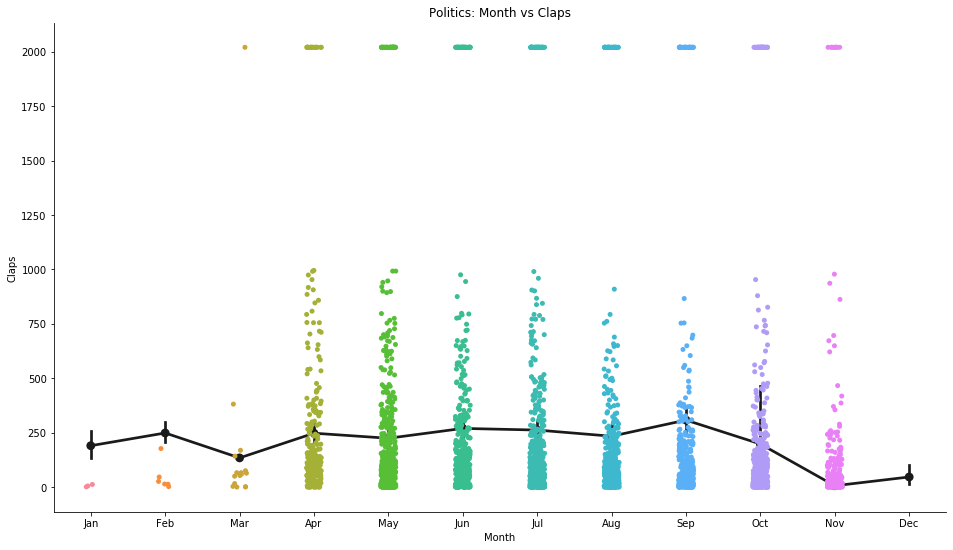

While most months seem to have similar clap averages, the average spikes in September likely because of election seasons, and dips after slowly because focus weens off of candidates.

<strong>Money</strong>

In [ ]:
plt.figure(figsize=(16, 9))

money_data1 = sns.pointplot(x="published", 
                            y="claps", 
                            data=money, 
                            color = ".1")

money_data1 = sns.stripplot(x="published", 
                            y="claps", 
                            data=money, 
                            order=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

money_data1.set_title("Money: Month vs Claps")
money_data1.set_ylabel("Claps")
money_data1.set_xlabel("Month")
sns.despine()

plt.show()

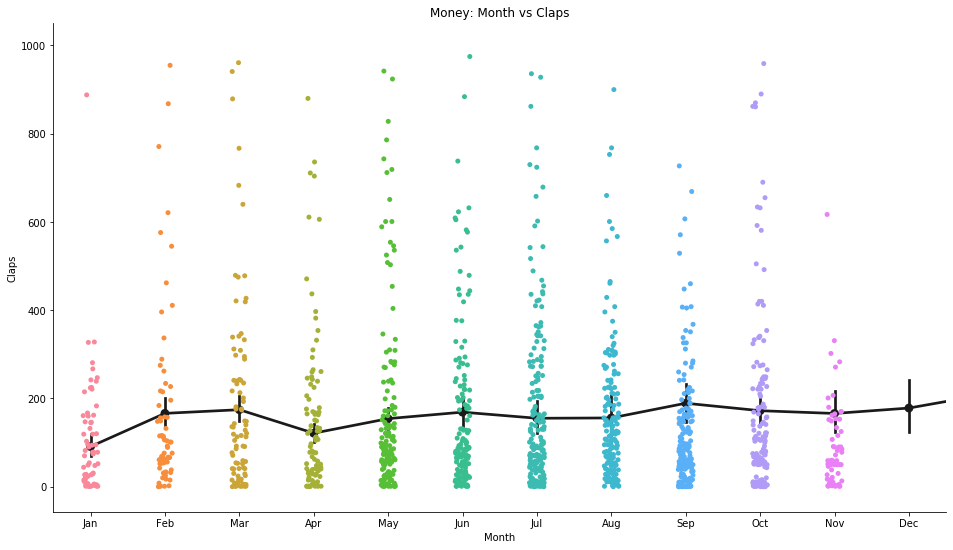

Once again, claps seem to have similar averages through months but the period between February and March is higher than others, potentially because this is when tax season is.

<strong>Art</strong>

In [ ]:
plt.figure(figsize=(16, 9))

art_data1 = sns.pointplot(x="published", 
                          y="claps", 
                          data=art, 
                          color = ".1")
art_data1 = sns.stripplot(x="published", 
                          y="claps", 
                          data=art, 
                          order=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

art_data1.set_title("Art: Month vs Claps")
art_data1.set_ylabel("Claps")
art_data1.set_xlabel("Month")
sns.despine()

plt.show()

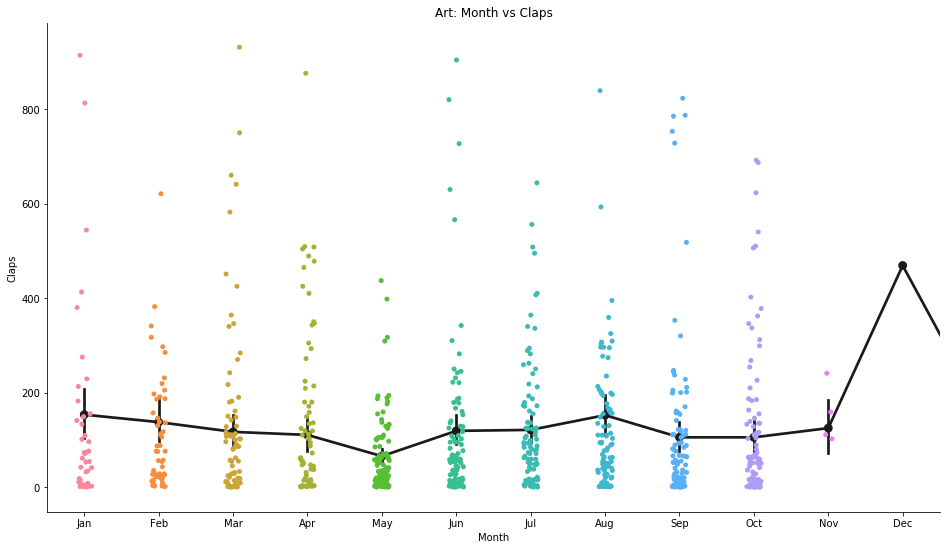

The averages through months are once again similar, with the exception of December due to an outlier data point. However, we see a rather sharp rise in average claps between the start of May through June, potentially because families could be planning a lot of visits to museums or other art galleries.

<h2>Title Length vs Claps Data</h2>

<strong>Politics</strong>

In [ ]:
pol_data2 = sns.jointplot("title_length", 
                          "claps", 
                          data=politics, 
                          kind="kde", 
                          space=0, 
                          color="r", 
                          height=5, 
                          ratio=5, 
                          ylim=(0,270), 
                          xlim=(10,80), 
                          dropna=True)

pol_data2.set_axis_labels("Title Length",
                          "Claps")

plt.show()

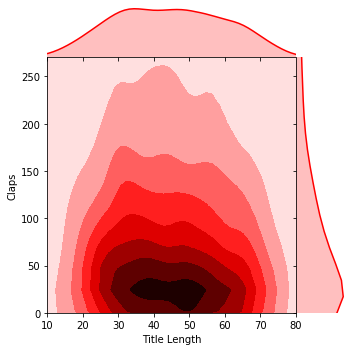

Most politics articles find themselves with titles between 35 and 55 characters and the claps seems to average between 10 and 40. 

<strong>Money</strong>

In [ ]:
money_data2 = sns.jointplot("title_length", 
                            "claps", 
                            data=money, 
                            kind="kde", 
                            space=0, 
                            color="g", 
                            height=5, 
                            ratio=5, 
                            ylim=(0,460), 
                            xlim=(10,80), 
                            dropna=True)

money_data2.set_axis_labels("Title Length", 
                            "Claps")

plt.show()

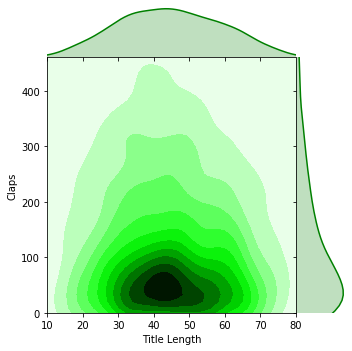

Most money articles find themselves with titles between 35 and 45 characters and the claps seems to average between 25 and 75. 

<strong>Art</strong>

In [ ]:
art_data2 = sns.jointplot("title_length", 
                          "claps", 
                          data=art, 
                          kind="kde", 
                          space=0, 
                          color="b", 
                          height=5, 
                          ratio=5, 
                          ylim=(0,270), 
                          xlim=(10,80), 
                          dropna=True)

art_data2.set_axis_labels("Title Length", 
                          "Claps")

plt.show()

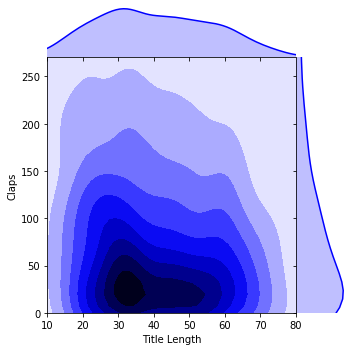

Most art articles find themselves with titles between 30 and 38 characters and the claps seems to average between 10 and 45. 

# Visualization - Tags
Jenna <br>
What were the most common tags in each topic that authors chose to use for their articles?

### Top 10 Tags in Technology 
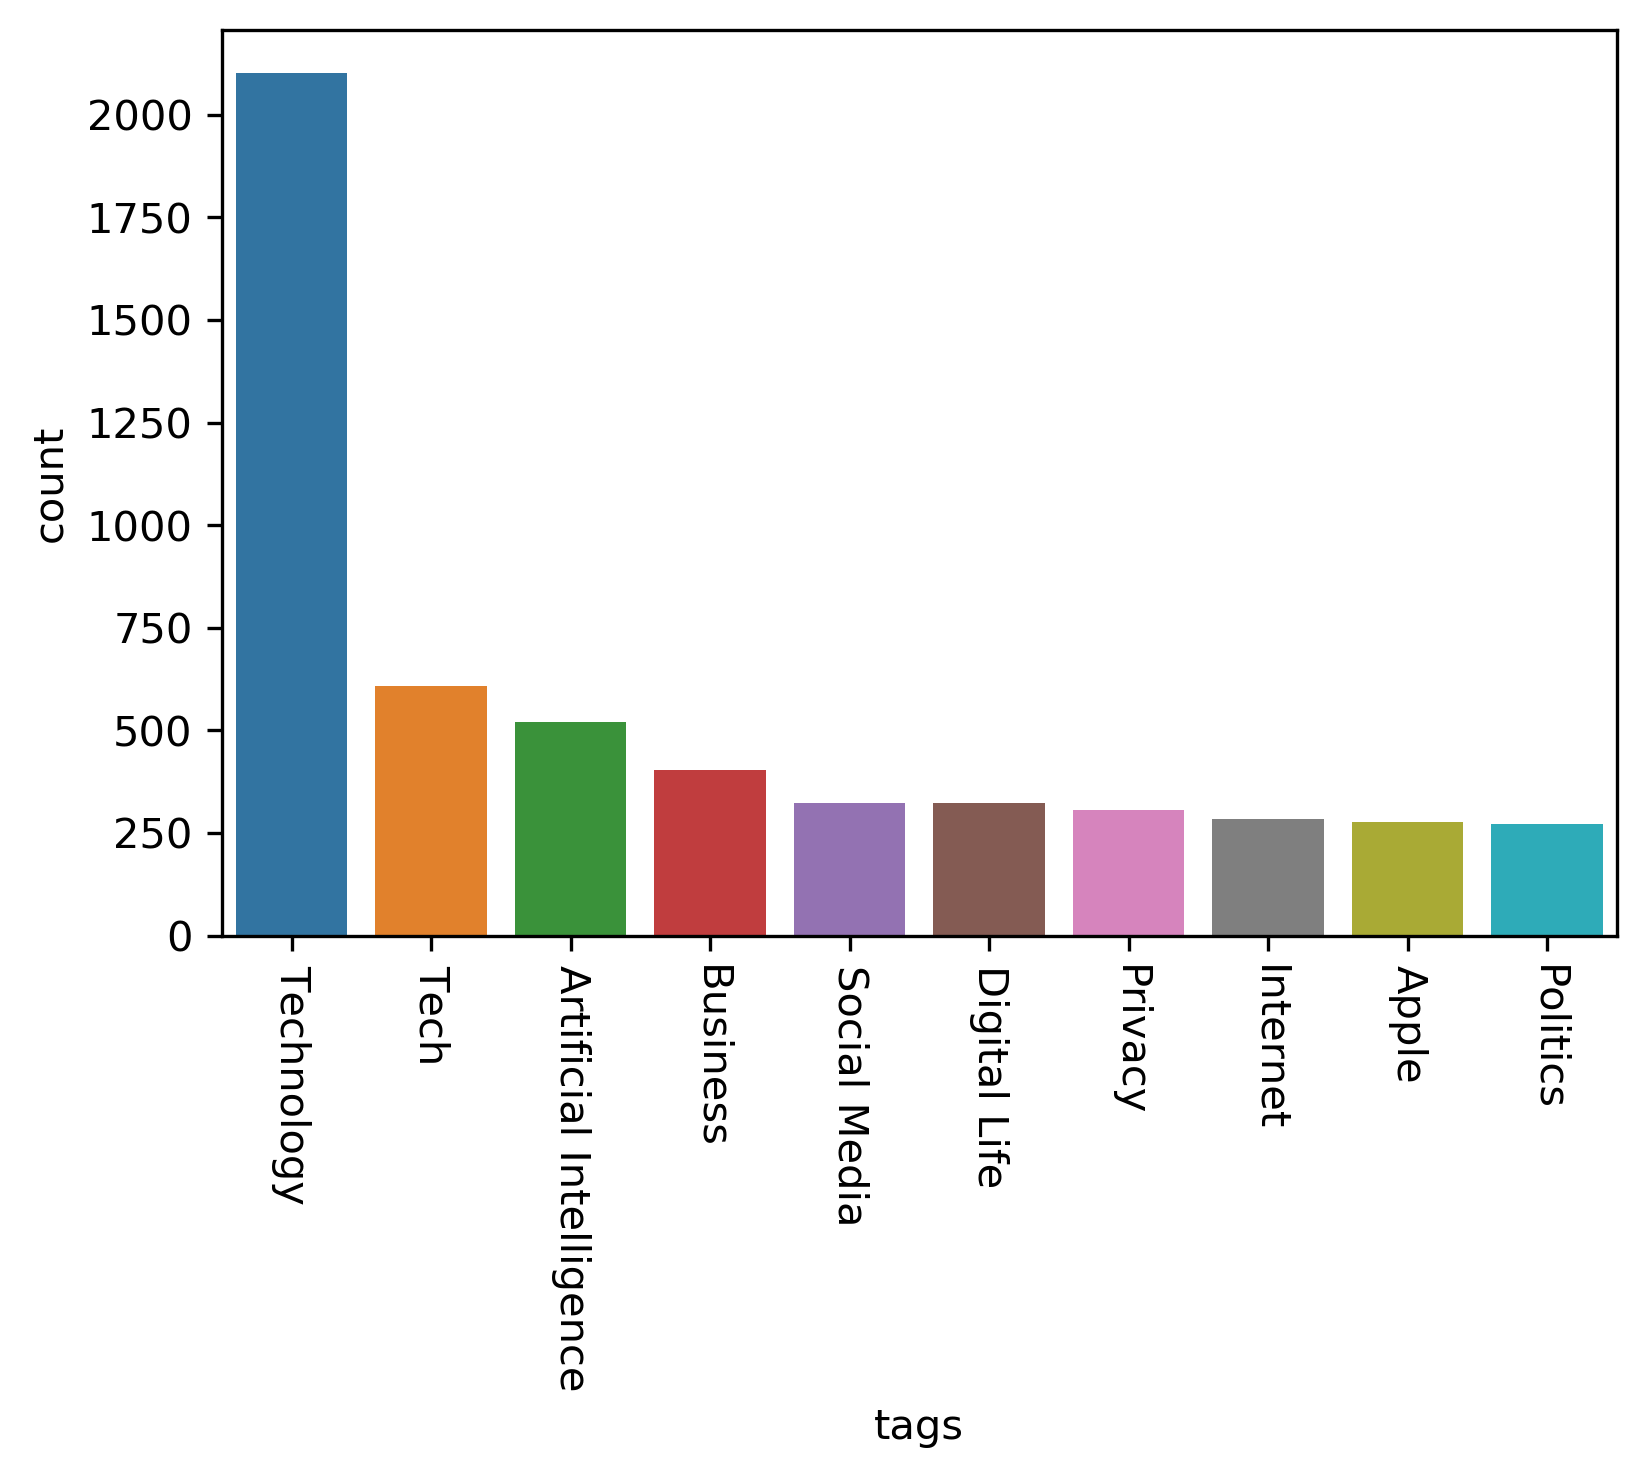

### Top 10 Tags in Money
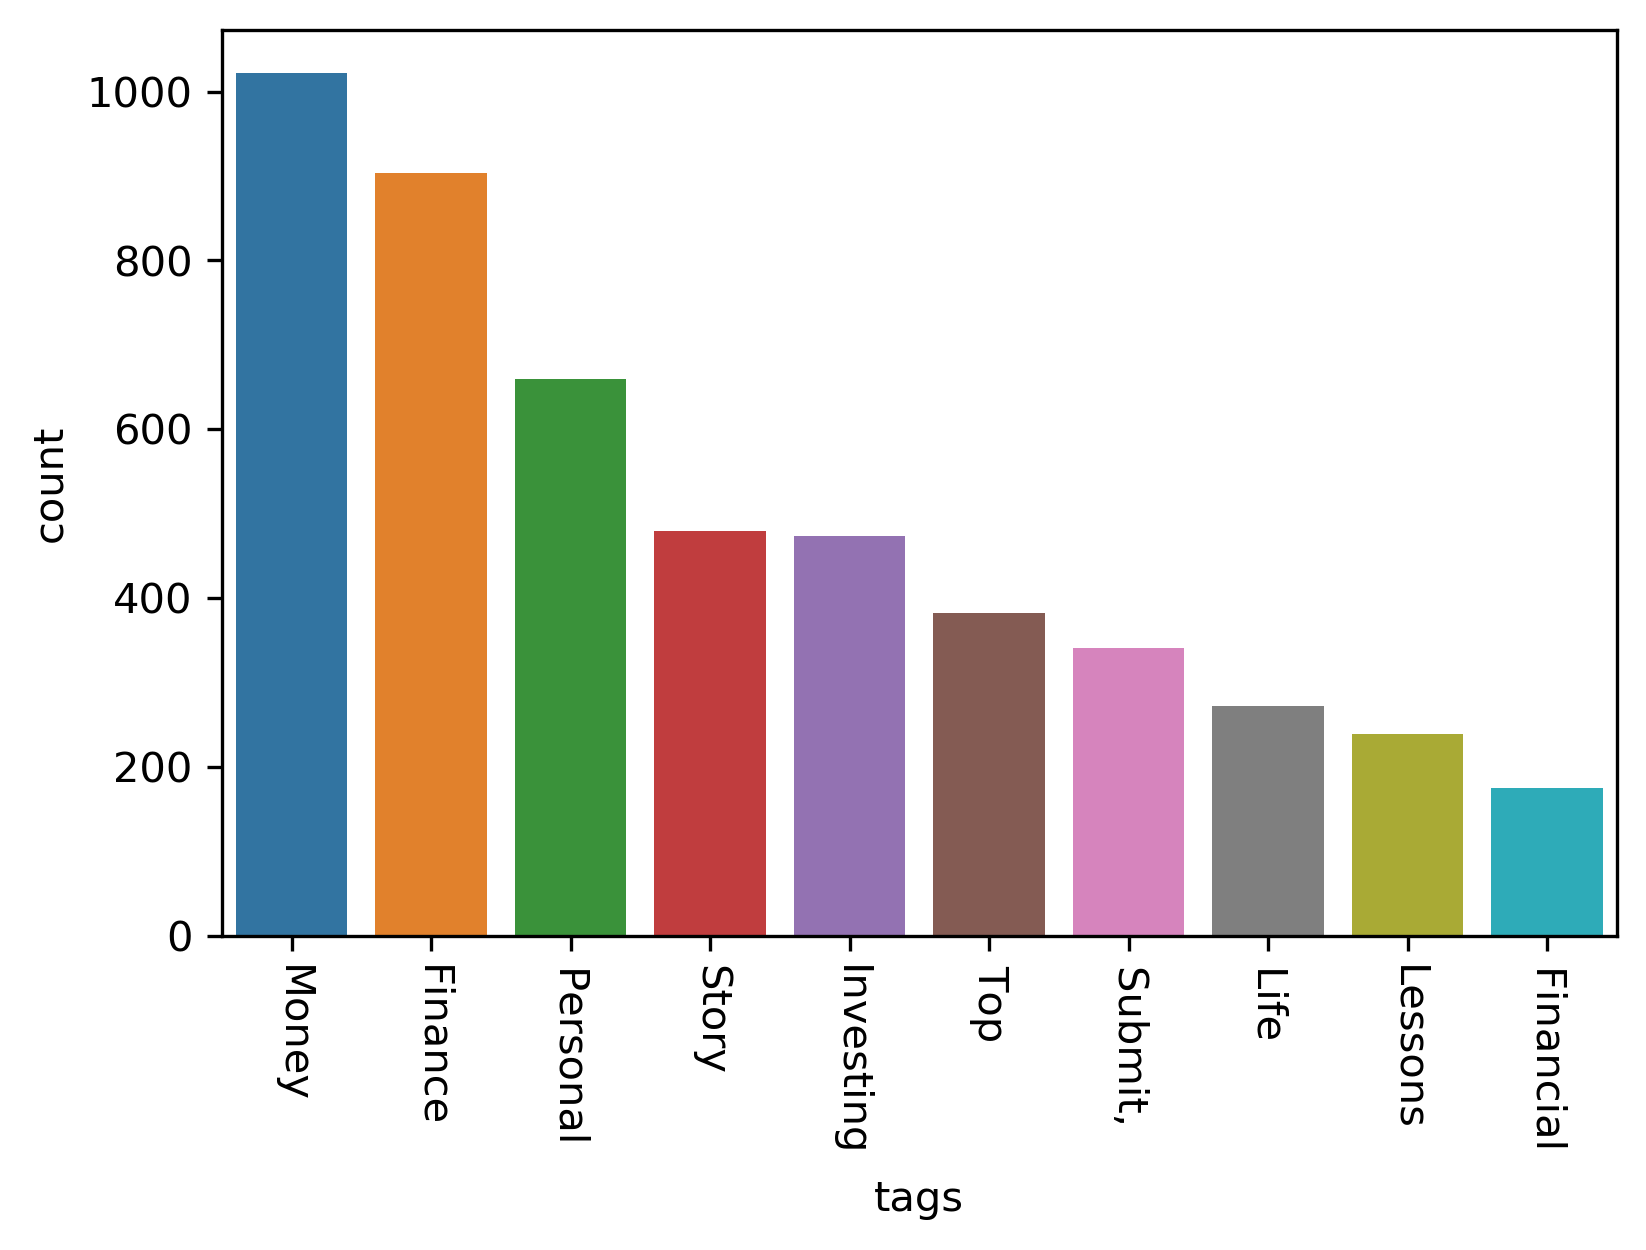

### Top 10 Tags in Politics
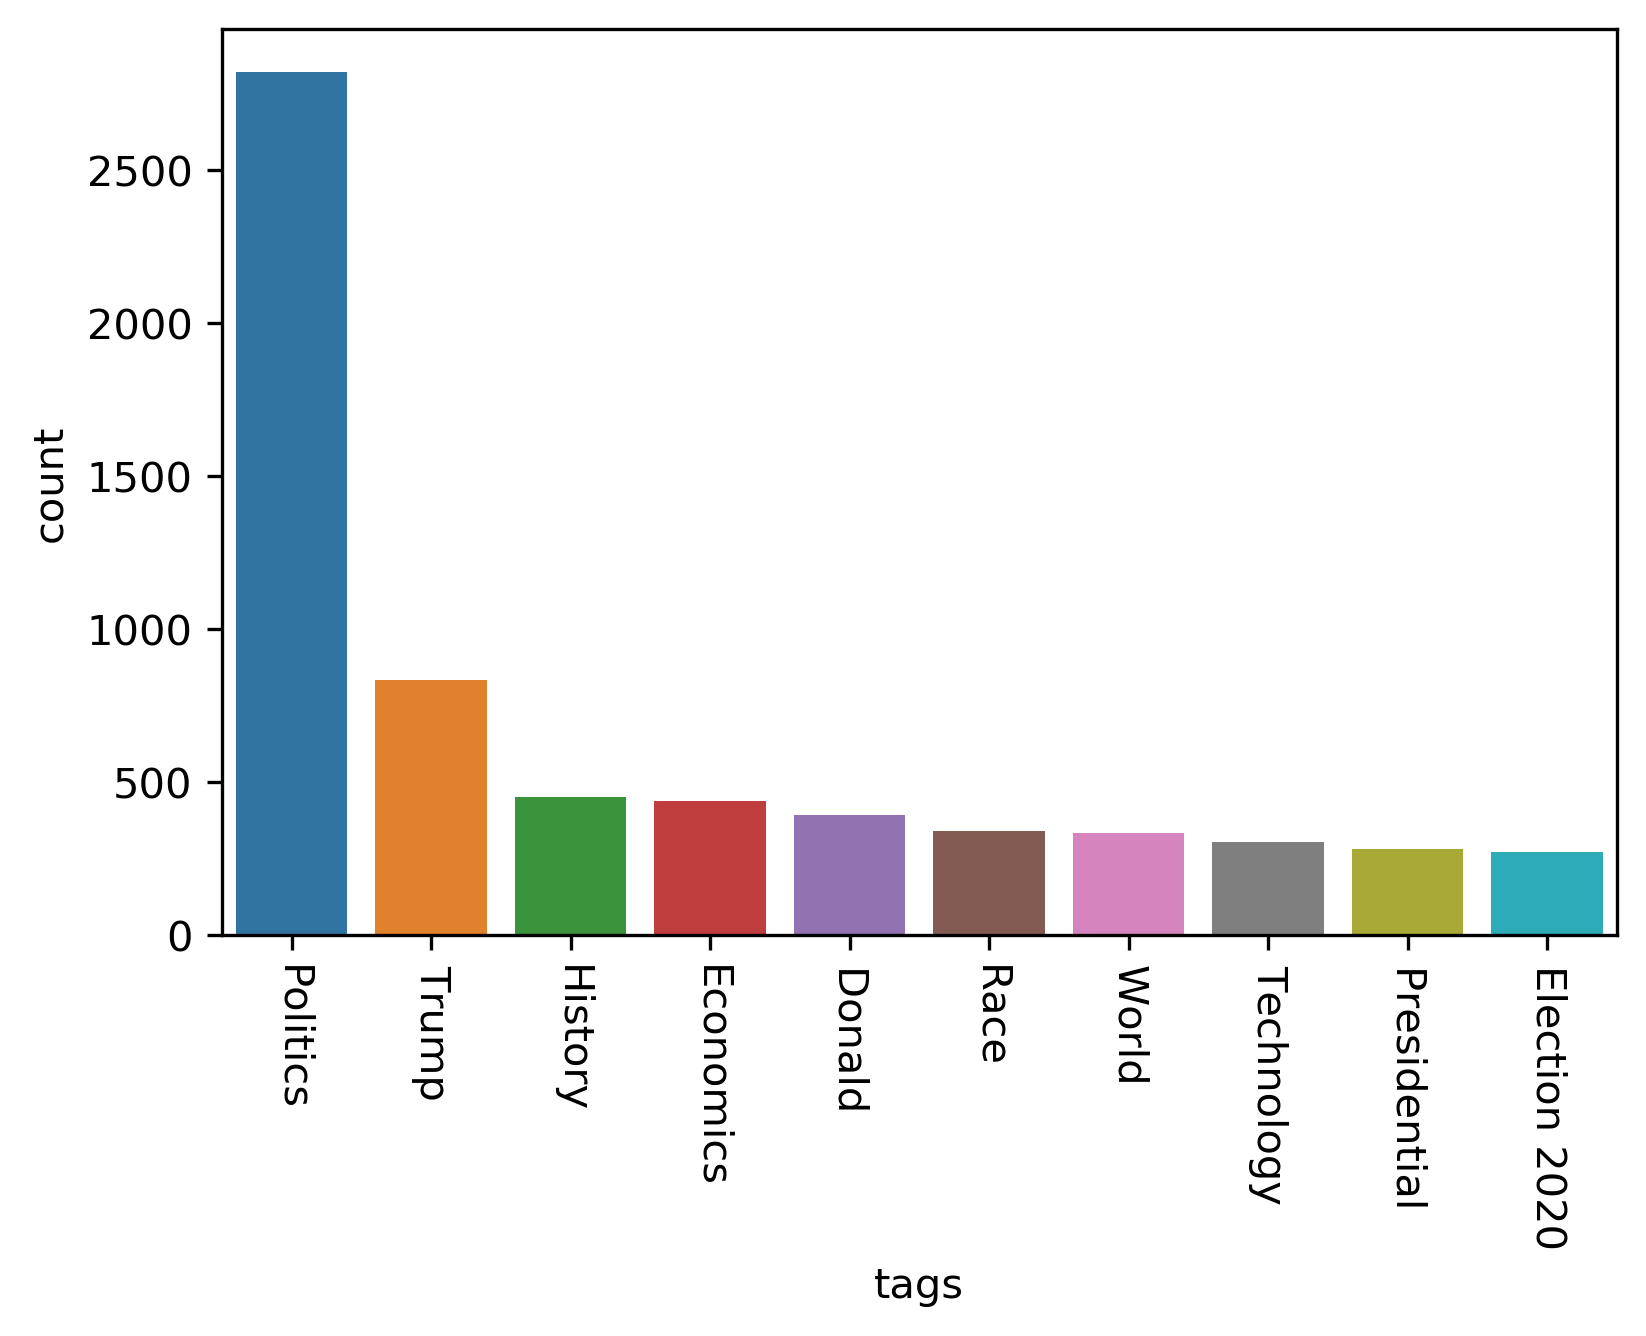

### Top 10 Tags in Sports
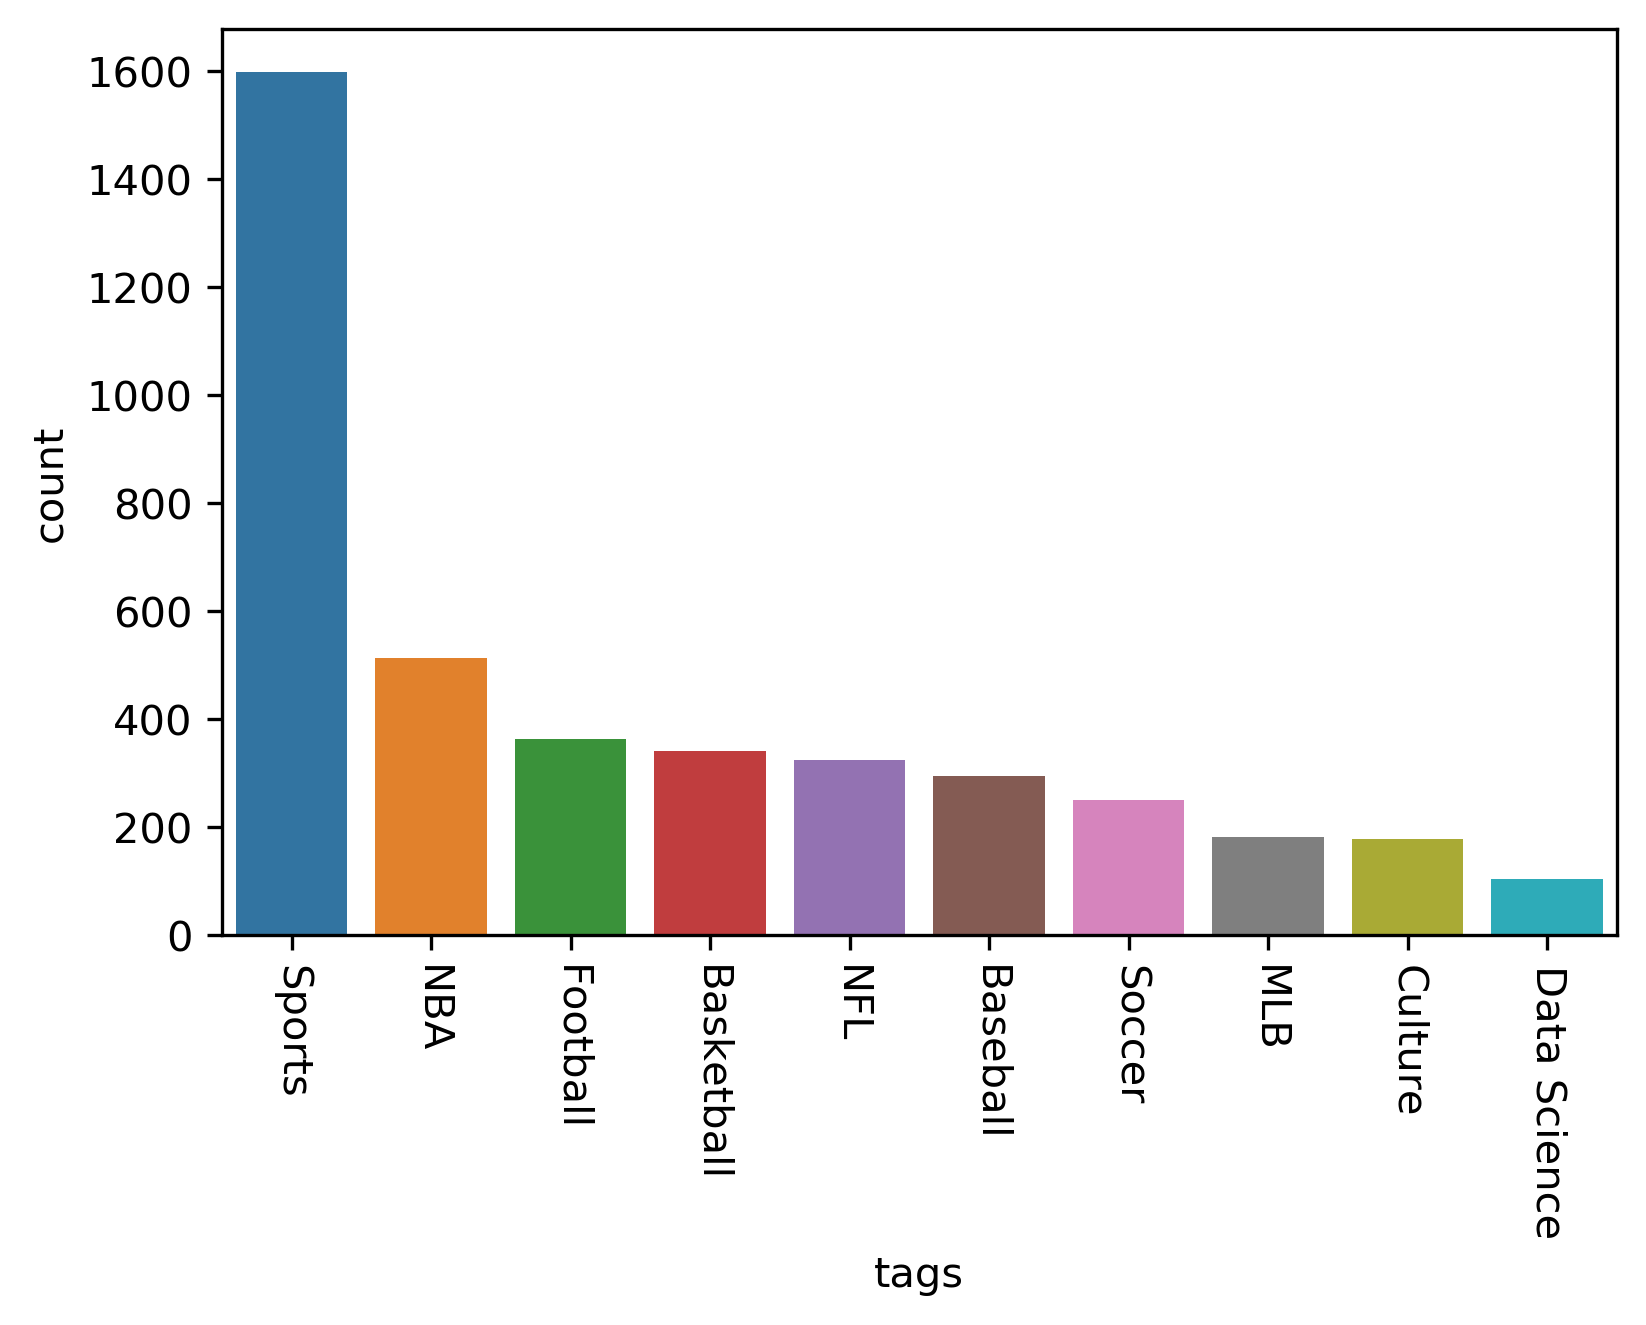

### Tag Visualization Notable Observations

- Most common tag among all topics: the topic itself
- Business and Politics notable in Technology
- Personal and Story in Money
- Data Science tag in Sports

# Modeling
Decision Trees, KNN, Regression

<h1>Decision Tree Classification and Modeling</h1>

In [ ]:
#saving scraped data to pandas dataframes
politics = pd.read_csv("../data/Politics_data_full.csv", index_col = 0)
politics.text.replace('[]', np.nan, inplace=True)
politics = politics.dropna(subset=["text"]).reset_index(drop=True)

money = pd.read_csv("../data/Medium_Money_Data_Final.csv", index_col = 0)
money.text.replace("[]", np.nan, inplace=True)
money = money.dropna(subset=["text"]).reset_index(drop=True)

sports = pd.read_csv("../data/medium-sports-data.csv", index_col = 0)
sports.text.replace("[]", np.nan, inplace=True)
sports = sports.dropna(subset=["text"]).reset_index(drop=True)

tech = pd.read_csv("../data/medium-tech-data.csv", index_col = 0)
tech.text.replace("[]", np.nan, inplace=True)
tech = tech.dropna(subset=["text"]).reset_index(drop=True)

politics.text, money.text, sports.text, tech.text

<h2>NLP</h2>

In [7]:
#down sample
np.random.seed = 42
pol = politics.sample(2000, replace= False)[["text"]].reset_index(drop=True)
mon = money.sample(len(money), replace = False)[["text"]].reset_index(drop=True)
spo = sports.sample(len(sports), replace = False)[["text"]].reset_index(drop=True)
tec = tech.sample(2000, replace = False)[["text"]].reset_index(drop=True)

In [8]:
#adding on the labels:
pol["label"] = [0] * len(pol)
mon["label"] = [1] * len(mon)
spo["label"] = [2] * len(spo)
tec["label"] = [3] * len(tec)

In [9]:
#need to split them up to train and test
len_mon = len(mon)
len_pol = len(pol)
len_tec = len(tec)
len_spo = len(spo)

In [10]:
#need to get train set
len_train_mon = int(len_mon * .80)
len_train_pol = int(len_pol * .80)
len_train_tec = int(len_tec * .80)
len_train_spo = int(len_spo * .80)

In [11]:
#train sets
train_mon = mon.iloc[:len_train_mon]
train_pol = pol.iloc[:len_train_pol]
train_tec = tec.iloc[:len_train_tec]
train_spo = spo.iloc[:len_train_spo]

#test sets
test_mon = mon.iloc[len_train_mon:]
test_pol = pol.iloc[len_train_pol:]
test_tec = tec.iloc[len_train_tec:]
test_spo = spo.iloc[len_train_spo:]

In [12]:
#need to combine all categories together for train
train = pd.concat([train_mon, train_pol, train_tec, train_spo],axis=0)

#need to combine all categories together for test
test = pd.concat([test_mon, test_pol, test_tec, test_spo],axis=0)

In [13]:
train = train.sample(frac = 1, replace = False).reset_index(drop=True)
test = test.sample(frac = 1, replace = False).reset_index(drop=True)

In [14]:
#get rid of null values
train = train[~pd.isnull(train["text"])]
test = test[~pd.isnull(test["text"])]

<h2>Hyperparameter Tuning</h2>

In [ ]:
#dict to keep my results:
tuning_dict = {}
i = 0

#making vectorizer:
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 100)

#a makeshift gridsearch:
for max_depth_i in range(1, 26):
    for min_samples_split_i in np.arange(.01, 0.26, .01):
        i = i + 1
        print(i)
        
        #this is how you create a basic decision tree
        dt = DecisionTreeClassifier(max_depth = max_depth_i, min_samples_split = min_samples_split_i)


In [ ]:
        #cross validation:
        kfold = KFold(n_splits = 3)
        for train_index, test_index in kfold.split(train):
            #split into train and test:
            X_train, X_test = train["text"].iloc[train_index], train['text'].iloc[test_index]
            Y_train, Y_test = train["label"].iloc[train_index], train['label'].iloc[test_index]

            #fit vectorizer on the train data:
            X_train_trans = vector.fit_transform(X_train)

            #DO NOT refit it onto the test data!
            X_test_trans = vector.transform(X_test)

            #fit on the decision tree
            dt.fit(X_train_trans, Y_train)
            test_scores = dt.score(X_test_trans, Y_test)
            train_scores = dt.score(X_train_trans, Y_train)

            #add to the dictionary

            tuning_dict[i] = {
                "train": np.mean(train_scores), 
                "test": np.mean(test_scores), 
                "max_depth": max_depth_i, 
                "min_samples_split": min_samples_split_i
            }

In [12]:
tuning_dict

{1: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.01},
 2: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.02},
 3: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.03},
 4: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.04},
 5: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.05},
 6: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.060000000000000005},
 7: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.06999999999999999},
 8: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,
  'max_depth': 1,
  'min_samples_split': 0.08},
 9: {'train': 0.44515832950894907,
  'test': 0.4593850390087196,


In [13]:
tuning_table = pd.DataFrame.from_dict(tuning_dict)

In [18]:
tuning_table_t = tuning_table.transpose().sort_values("train", ascending=False)
md = tuning_table_t["max_depth"].iloc[0]
mss = tuning_table_t["min_samples_split"].iloc[0]
tuning_table.transpose()

,train,test,max_depth,min_samples_split
1,0.445158,0.459385,1.0,0.01
2,0.445158,0.459385,1.0,0.02
3,0.445158,0.459385,1.0,0.03
4,0.445158,0.459385,1.0,0.04
5,0.445158,0.459385,1.0,0.05
...,...,...,...,...
621,0.775815,0.733364,25.0,0.21
622,0.775815,0.733364,25.0,0.22
623,0.761358,0.725562,25.0,0.23
624,0.761358,0.725562,25.0,0.24


In [16]:
#optimized decision tree
dt = DecisionTreeClassifier(max_depth = md, min_samples_split = mss)

In [17]:
#final vector written here (no max number of features)
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = None)

#fit the tfidf on all the train data:
train_final = vector.fit_transform(train["text"])

#the final transformation and fitting before using the test data:
test_final = vector.transform(test["text"])

In [18]:
#fit model on FULL train data
dt.fit(train_final, train["label"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
#score it on the test data
final_score = dt.score(test_final, test["label"])

#the final score
final_score

0.8311926605504587

<h2>Confusion Matrix</h2>

In [31]:
#get predictions from the decision tree
predictions = dt.predict(test_final)
predictions

array([0, 3, 1, ..., 2, 3, 3], dtype=int64)

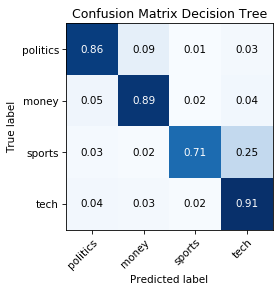

In [85]:
# helper function defined
normed_cm(test["label"],predictions);
plt.title("Confusion Matrix Decision Tree");


# Modeling - K nearest neighbors

Building a KNN Classifer model with the text data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### Part 1: Breaking data into training and test sets

After cleaning the data and randomly sampling 2000 from each topic, we need to split our data in each of our 4 topics into train and test sets.   



In [ ]:
train.head()

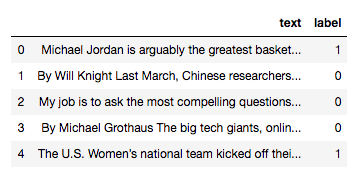

### Part 2: Scoring our words with TFIDFVectorizer

In [ ]:
#transforming the data, manipulating it based on the weights we 
#determined before by fitting our data 
train_transformed = vector.transform(X_train)
test_transformed = vector.transform(X_test)

#splitting
train_test_split(train_transformed, Y_train)[0], train_test_split(train_transformed, Y_train)[1]

(<4902x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 48487 stored elements in Compressed Sparse Row format>,
 <1635x50 sparse matrix of type '<class 'numpy.float64'>'
 	with 16097 stored elements in Compressed Sparse Row format>)

### Part 3: Hyperparameter Tuning and Cross Validation

Finding the best k by performing cross validation 

In [ ]:
#Cross Validation for k

# creating odd list of k for KNN (to prevent ties)
neighbors = list(range(1, 50, 2))
# empty list that will hold cv scores
cv_scores = []


# perform 10-fold cross validation
for k in neighbors:
    knearest = knn(n_neighbors = k)
    scores = cross_val_score(knearest, train_transformed, Y_train, cv = 10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# plot of accuracies for different k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

### Cross Validation Results
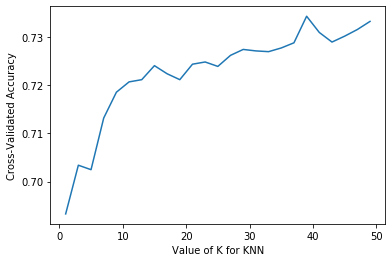

- peak starting from k > 10, slowly decreases around 30 

### More hyperparameter tuning: trying different k's


In [ ]:
#Trying different k values - which produces highest score
knn_scores = []

for i in range(1, 50, 2):
    knearest = knn(n_neighbors = i)
    knearest.fit(train_transformed, Y_train)
    
    knn_scores.append(knearest.score(test_transformed, Y_test))

knn_scores

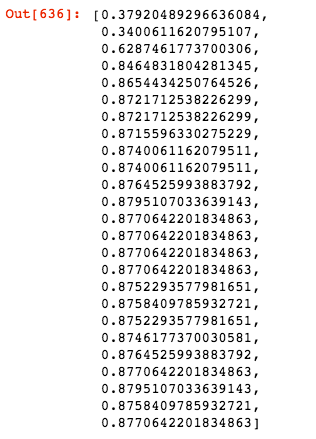

In [ ]:
best_k = (knn_scores.index(max(knn_scores)) + 1) * 2 - 1
best_k

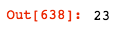

### Part 4: Create the Model with chosen k


In [ ]:
#create the KNN model
knearest = knn(n_neighbors = 23)

#fit the model with training data
knearest.fit(train_transformed, Y_train)


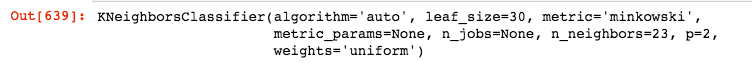

In [ ]:
knearest.score(test_transformed, Y_test)

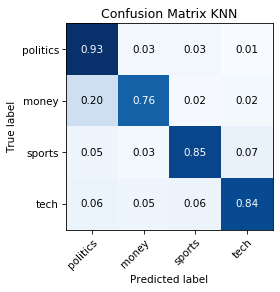

In [89]:
#function defined elsewhere
normed_cm(Y_test, knearest.predict(test_transformed));
plt.title("Confusion Matrix KNN");


## Implementing a Multinomial Naive Bayes Classification Model
Shinu

In [156]:
lst_model = []
train_accuracy = []
test_accuracy = []

Since the Multinomial Naive Bayes Model works best with text data hence all other features such as followers and following were removed from the feature set. The only features used and worked best with the classifier are <b>text, tag and title</b>. <br>

With stopwords:

In [157]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1])), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,1)), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,1)), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9578
Validation accuracy: 0.9192


In [158]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1])), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,2)), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,2)), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9565
Validation accuracy: 0.8930


Without stopwords:

In [159]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1]),stop_words='english'), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,1),stop_words='english'), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,1),stop_words='english'), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9664
Validation accuracy: 0.9352


In [160]:
preprocess = ColumnTransformer(
    [('tags_tfidf', tfidf(ngram_range=([1, 1]),stop_words='english'), 'tags'),
         ('text_tfidf', tfidf(ngram_range=(1,2),stop_words='english'), 'text'),
    ('title_tfidf', tfidf(ngram_range=(1,2),stop_words='english'), 'title')])
model = make_pipeline(
    preprocess,
    MultinomialNB())
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_val)
lst_model.append(model)

train_rmse = accuracy_score(y_train_pred, y_train)
test_rmse = accuracy_score(y_pred, y_val)
train_accuracy.append(train_rmse)
test_accuracy.append(test_rmse)
print('Train accuracy: %.4f' % train_rmse)
print('Validation accuracy: %.4f' % test_rmse)

Train accuracy: 0.9731
Validation accuracy: 0.9196


In [173]:
train_val = []
for i in range(len(train_accuracy)):
    temp = []
    if i==0 or i==1:
        temp.append('include stop-words')
    if i==2 or i==3:
        temp.append('remove stop-words')
    if i==0 or i==2:
        temp.append('unigrams')
    if i==1 or i==3:
        temp.append('unigrams and bigrams')
    temp.append(train_accuracy[i])
    temp.append(test_accuracy[i])
    train_val.append(temp)
compiled_models = pd.DataFrame(train_val, columns=['Stop-Words','Unigrams/Bigrams','Train Accuracy','Validation Accuracy'])

The model was further optimised by playing with ngrams when converting text, tag and title to tfidf.<br>
The best combination of ngrams was unigrams for tags, text and title. Converting the tfidf to either unigrams or bigrams for any of the features resulted in the training data to be overfit, hence, the validation score would drop.

In [174]:
compiled_models

,Stop-Words,Unigrams/Bigrams,Train Accuracy,Validation Accuracy
0,include stop-words,unigrams,0.957761,0.919229
1,include stop-words,unigrams and bigrams,0.956531,0.892989
2,remove stop-words,unigrams,0.966373,0.935219
3,remove stop-words,unigrams and bigrams,0.973139,0.919639


In [186]:
y_test_pred = lst_model[2].predict(X_test)
print('Test accuracy: %.4f' % accuracy_score(y_test_pred, y_test))

Test accuracy: 0.9381


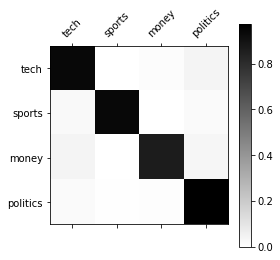

In [189]:
C = confusion_matrix(y_test, y_test_pred)
C = C / C.astype(np.float).sum(axis=1)
classes = ['tech', 'sports','money','politics']
df_confusion = pd.DataFrame(C, columns=classes, index=classes)
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

# What Did We Learn?
<img src = 'think.png' Think>

# What I learned
- Webscraping with BeautifulSoup
- ML Algorithms: KNN, decision trees
- NLP: tfidf
- Process of a data science project: getting data --> model building

# Future Direction
<img src = 'keywords.png'>

# References:
- Medium: https://medium.com/
- Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- NLTK package: Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.
- https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
- https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
- https://blog.floydhub.com/gentle-introduction-to-text-summarization-in-machine-learning/
- https://www.geeksforgeeks.org/implementing-web-scraping-python-beautiful-soup/
- https://moz.com/learn/seo/robotstxt

A special thanks to Ahan for his guidance throughout the quarter.

# Thank you!